In [1]:
import pickle
import os
import glob
import re
import sys
import pandas as pd
import folktables as ft
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ModuleNotFoundError: No module named 'seaborn'

In [2]:
results_dir = os.getcwd

scores_dicts = pickle.load(open( "accuracy_dicts.pkl", "rb" ))
confusion_dicts = pickle.load(open( "equal_opp_dicts.pkl", "rb" ))


states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO',  'DC', 'DE', 'FL', 'GA',
          'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
          'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
          'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
          'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
# remove missing wy, nm, nj , 'ID', 'IL', 'IN', 'KS''FL', 'GA', 'DC', 'CT' 'CT',
states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO',  'DE', 
          'HI', 'IA', 'KY', 'LA', 'MA', 'MD', 'ME',
          'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH',
          'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
          'UT', 'VA', 'VT', 'WA', 'WI', 'WV']

states.sort()

states_reverse = states[::-1]


In [452]:
scores_dicts['AK']['AL']

{0.0: 0.7568248635027299,
 0.1: 0.7568248635027299,
 0.2: 0.7568248635027299,
 0.30000000000000004: 0.7574548509029819,
 0.4: 0.7574548509029819,
 0.5: 0.7574548509029819,
 0.6000000000000001: 0.745905081898362,
 0.7000000000000001: 0.7750944981100378,
 0.8: 0.746745065098698,
 0.9: 0.7675346493070139,
 1.0: 0.7656446871062579}

### Accessing the Dictionaries
 
scores_dicts is accuracy on Public Coverage accessed by source,target,lambda
ex: scores_dicts['AK']['WV'][0.5] = 0.683008356545961

confusion_dicts is the Equal Opportunity Score (White people - Black people), same format
ex: confusion_dicts['AK']['WV'][0.5] = -0.07709367012479323



### Functions for creating DataFrames to use for Graphics

In [477]:
# accuracy scores by source, target

def df_accuracy_source_target():
    df = pd.DataFrame(columns=states_reverse, index=states)
    for key, value in scores_dicts.items():
        for k, v in value.items():
            df.loc[key][k] = max(v.values())
    df = df.replace({np.nan:-10})
    return df


# accuracy scores by source, target
# normalized as within domain - source, target, at selected lambda
def df_accuracy_source_target_normalized(alpha):
    df = pd.DataFrame(columns=states_reverse, index=states)
    for source, t_values in scores_dicts.items():
        for target, values in t_values.items():
            try:
                base_accuracy = scores_dicts[source][target][1.0]
                df.loc[source][target] = values[alpha] - base_accuracy
            except:
                pass
    df = df.replace({np.nan:-1000})
    # multiply by 100 to get readable percentage point difference
    return df*100


# eo scores by source, target
def df_eo_source_target(alpha):
    df = pd.DataFrame(columns=states_reverse, index=states)
    for key, value in confusion_dicts.items():
        for k, v in value.items():
            try:
                df.loc[key][k] = v[alpha]
            except:
                pass
    df = df.replace({np.nan:100})
    return df


# accuracy scores by source, target
# normalized as within domain - source, target, at selected lambda
def df_eo_source_target_normalized(alpha):
    df = pd.DataFrame(columns=states_reverse, index=states)
    for source, t_values in confusion_dicts.items():
        for target, values in t_values.items():
            try:
                baseline = confusion_dicts[source][target][1.0]
                df.loc[source][target] = abs(values[alpha]) - abs(baseline)
            except:
                pass
    df = df.replace({np.nan:-1000})
    # multiply by 100 to get readable percentage point difference
    return df*100


def confusion_matrix_values(y_test, predictions):
    """Calculate confusion matrix rates for population or subgroup"""
    cm = confusion_matrix(y_test, predictions)
    TN, FP, FN, TP = cm.ravel()

    N = TP + FP + FN + TN  # Total population
    ACC = (TP + TN) / N  # Accuracy
    TPR = TP / (TP + FN)  # True positive rate
    FPR = FP / (FP + TN)  # False positive rate
    FNR = FN / (TP + FN)  # False negative rate
    PPP = (TP + FP) / N  # % predicted as positive

    return np.array([ACC, TPR, FPR, FNR, PPP])


# accuracy scores by source, target
def standard_tree_df(accuracy_dict, predictions_dict, X_test, y_test):
    df = pd.DataFrame(columns=states, index=['Accuracy_all', 'Acc_white', 'Acc_black'])
    for key, predictions in predictions_dict.items():
        try:
            confusion_values_black = confusion_matrix_values(y_test[key][(X_test[key]['RAC1P'] == 2)],
                                                         predictions['prediction']
                                                     [(X_test[key].reset_index()['RAC1P'] == 2)])
            confusion_values_white = confusion_matrix_values(y_test[key][(X_test[key]['RAC1P'] == 1)], 
                                                     predictions['prediction']
                                                             [(X_test[key].reset_index()['RAC1P'] == 1)])
            df.loc['Accuracy_all'][key] = accuracy_dict[key]
            df.loc['Acc_white'][key] = confusion_values_white[0]
            df.loc['Acc_black'][key] = confusion_values_black[0]
        except:
#             print(f'failed at {key}')
            pass
    df = df.replace({np.nan:-10})
    return df

## Creating Graphics Using Above Functions

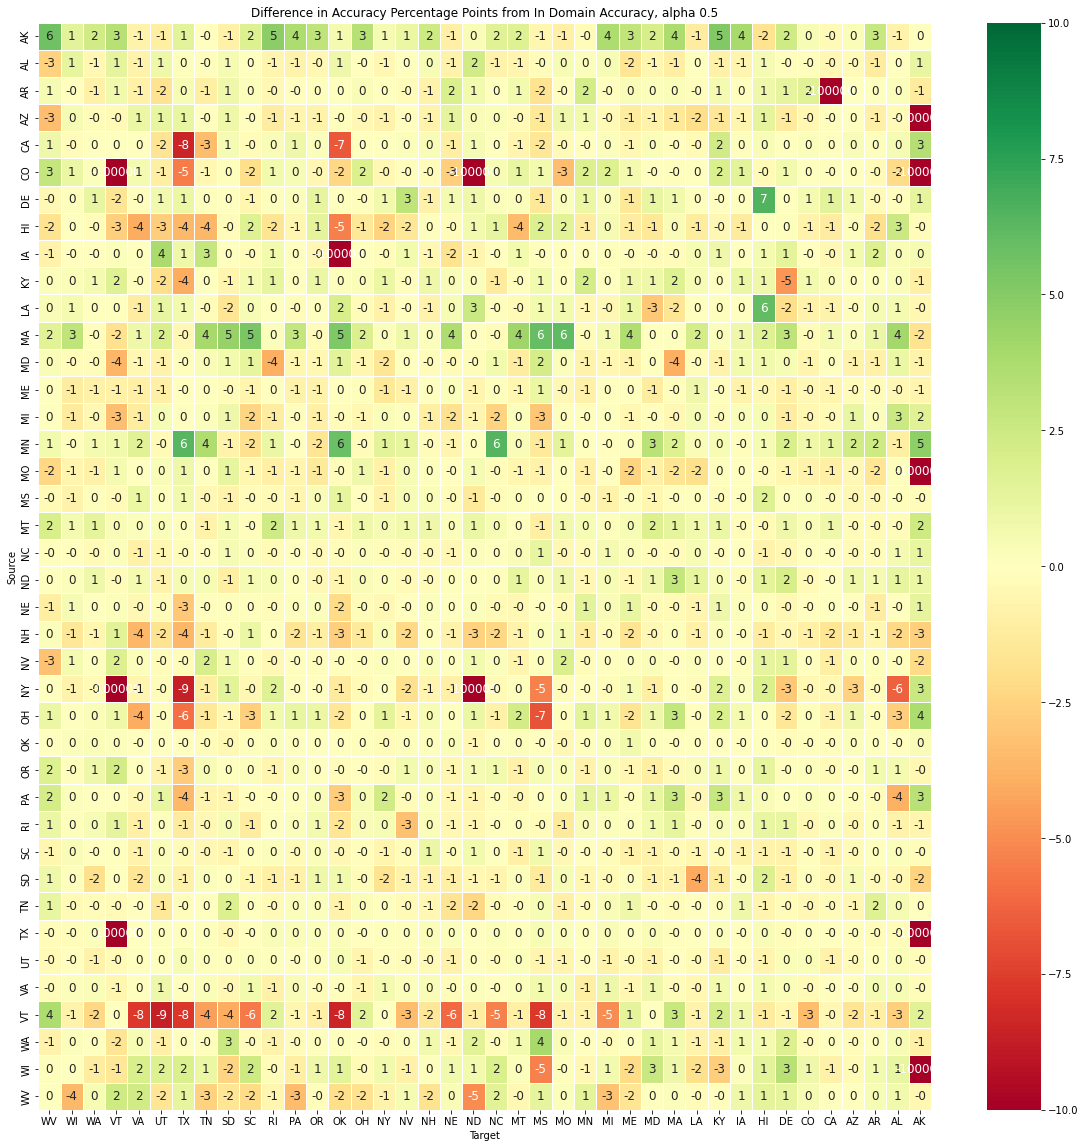

In [470]:
alpha = 0.5
df = df_accuracy_source_target_normalized(alpha) 
# df = df_eo_source_target()
fig, ax_a = plt.subplots(figsize=(20, 20))
ax_a = sns.heatmap(df, linewidth=0.5, vmin=-10, vmax=10, cmap='RdYlGn', center=0,
                  annot=True, annot_kws={"size": 12}, fmt='.0f')

ax_a.set(xlabel='Target', ylabel='Source', title=f'Difference in Accuracy Percentage Points from In Domain Accuracy, alpha {alpha}')

plt.show()

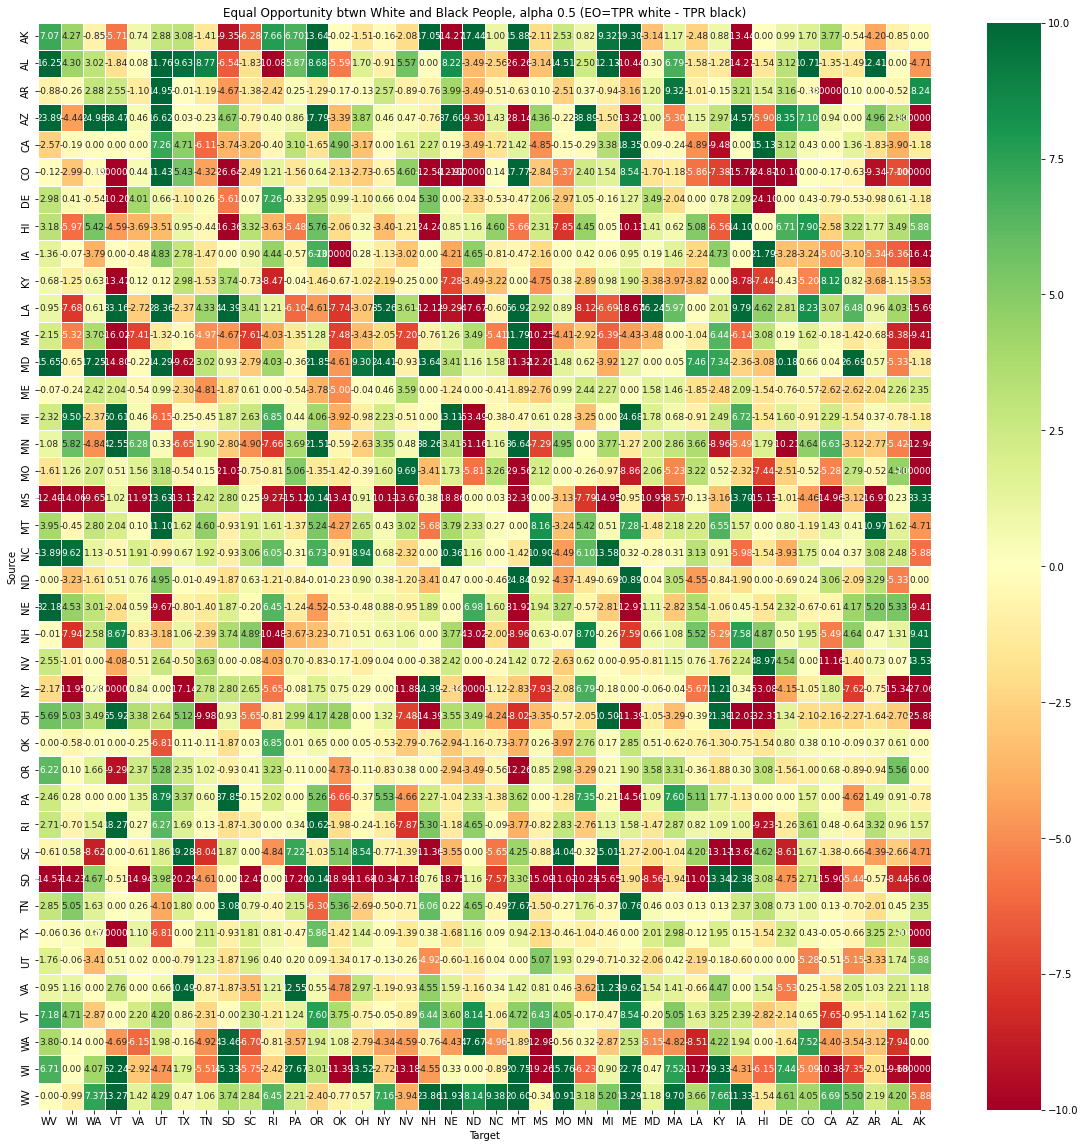

In [479]:
alpha = 0.5
df_eo = df_eo_source_target_normalized(alpha) 
# df = df_eo_source_target()
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(df_eo, linewidth=0.5, vmin=-10, vmax=10, cmap='RdYlGn', center=0,
                  annot=True, annot_kws={"size": 9}, fmt='.2f')

ax.set(xlabel='Target', ylabel='Source', title=f'Equal Opportunity btwn White and Black People, alpha {alpha} (EO=TPR white - TPR black)')

plt.show()

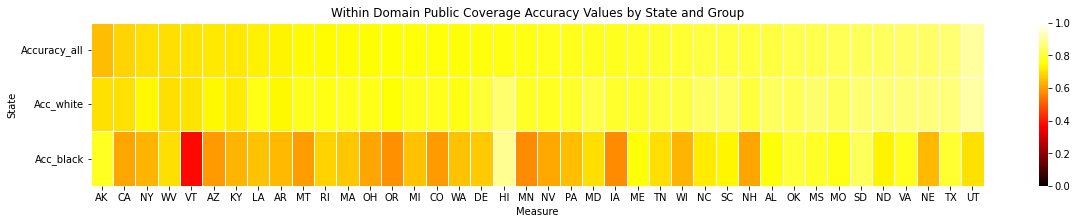

In [443]:
standard_tree_accuracy = pickle.load(open("../domain-adaptive-trees/results/standard_tree_accuracy.pkl", "rb" ))
standard_tree_predictions = pickle.load(open("../domain-adaptive-trees/results/standard_tree_predictions.pkl", "rb" ))
y_test_dict = pickle.load(open("../domain-adaptive-trees/results/y_test.pkl", "rb" ))
x_test_dict = pickle.load(open("../domain-adaptive-trees/results/x_test.pkl", "rb" ))

df = standard_tree_df(standard_tree_accuracy, standard_tree_predictions,
                      x_test_dict, y_test_dict)

fig, ax_ = plt.subplots(figsize=(20, 3))
df = pd.DataFrame(df, dtype="float").sort_values(by='Accuracy_all', axis = 1)
ax = sns.heatmap(df, linewidth=0.5, vmin=0.0, vmax=1.0, cmap='hot')

ax.set(xlabel='Measure', ylabel='State', title='Within Domain Public Coverage Accuracy Values by State and Group')

plt.show()

### Reshaping Data and Dictionaries

In [437]:
# load dicts into a dict with source state as key
def load_all_dicts(result='scores'):
    all_dicts = {}
    for file in os.listdir(results_dir):
        if file.startswith(result):
            results_dict = pickle.load(open(os.path.join(
                results_dir, file), 'rb'))    
            for key, values in results_dict.items():
                source_state = key[0]
                target_state = key[1]
                if source_state not in all_dicts.keys():
                    all_dicts[source_state] = {}
                all_dicts[source_state][target_state] = values                   
    return all_dicts


# make table of sorted accuracy of each state on task (source==target),EO
def get_no_shift_values(scores_dicts, confusion_dicts):
    no_shift_dict = {}
    for key, values in scores_dicts.items():
        # access state == target values
        try:
            acc = values[key][0]
        except:
            acc = None
        try:
            eo = confusion_dicts[key][key][0]
        except:
            eo = None
        # todo: put in a check that those things stay the same across lambda
        no_shift_dict[key] = [acc, eo]
    return no_shift_dict


# Next, get accuracy shift for each state to state comparison?
def find_best_domain_shift_accuracy(scores_dicts):
## For each (source, target) find 'best' lambda for goal metric
    tops_dict = {}
    for source_key, source_value in scores_dicts.items():
        # source value is dict every target state for this source state')
        for target_key, target_value in source_value.items():
            # target_value is accuracy for each lamba for this source target')
            top = 0
            for lmda, value in target_value.items():
#                 if value >= top:
                if abs(scores_dicts[source_key][source_key][lmda]-value) >=top:
                    top = value # source_key,source_key,lmda-value
                    top_keys = (source_key, target_key)
                    top_values = [lmda, top]
            tops_dict.update({top_keys:top_values})
    return tops_dict
            
            
def add_best_domain_shift_EO(confusion_dicts, tops_dict):
    for source_key, source_value in confusion_dicts.items():
        # source value is dict every target state for this source state')
        for target_key, target_value in source_value.items():
            # target_value is accuracy for each lamba for this source target')
            top = 2.1
            for lmda, value in target_value.items():
#                 if abs(value) < top:
                if abs(scores_dicts[source_key][source_key][lmda]-value):
                    top = value
                    top_eo_values = [lmda, value]
            top_values = tops_dict[source_key, target_key]
            top_values.append(top_eo_values[0])
            top_values.append(top_eo_values[1])
#             print(top_values)  
            tops_dict[source_key, target_key] = top_values
#             print(tops_dict[source_key, target_key])
    print(tops_dict[source_key, target_key])

    return tops_dict



no_shift_dict = get_no_shift_values(scores_dicts, confusion_dicts)
no_shift_df = pd.DataFrame.from_dict(no_shift_dict, orient='index',  
                                     columns=['Accuracy', 'Equal Opportunity']).sort_values(by=['Accuracy'], 
                                                                                            ascending=False)


In [84]:
# find missing states in results dicts

for state in states:
    missing_targets = []
    for inner_state in states:
        try:
            dummy = scores_dicts[state][inner_state]
        except:
            print(inner_state)
            missing_targets.append(inner_state)

print(missing_targets.sort())

DC
WY
DC
WY
CA
DC
WY
AK
DC
WY
DC
WY
AK
DC
ND
VT
WY
AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY
AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY
DC
WY
DC
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY
AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY
DC
WY
DC
OK
WY
DC
VA
VT
WA
WI
WV
WY
AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY
AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY
AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
N

In [ ]:
# Run to load new data from alternative directory and then add to the main dicts
# Note, it will overide values when the source target already exists in the main dicts

results_dir = '../domain-adaptive-trees/results_additional_2/'



def update_scores_dicts(new_dicts):
    for s_key, s_dict in scores_dicts_append.items():
        for target, values in s_dict.items():
            if s_key in scores_dicts.keys():
                scores_dicts[s_key][target] = values
            else:
                scores_dicts[s_key] = {target : values}               


def update_eo_dicts(new_dicts):
    for source_key, c_dict in confusion_dicts_append.items():
        for target, values in c_dict.items():
            print(source_key, target)
            if source_key in confusion_dicts.keys():
                confusion_dicts[source_key][target] = values
            else:
                confusion_dicts[source_key] = {target : values}
                        
            
scores_dicts_append = load_all_dicts('scores')
update_scores_dicts(scores_dicts_append)


confusion_dicts_append = load_all_dicts('confusion')
update_eo_dicts(confusion_dicts_append)


# set dir back to default
results_dir = '../domain-adaptive-trees/results/'

In [66]:
# pickle the main dicts after you update them

pickle.dump(scores_dicts, open( "accuracy_dicts.pkl", "wb" ))
pickle.dump(confusion_dicts, open( "equal_opp_dicts.pkl", "wb" ))